<a href="https://colab.research.google.com/github/Tim-Li/X-ray_summer_school_2022/blob/main/code/Python%E5%AF%A6%E4%BD%9C_Day1%EF%BC%9APython%E5%9C%A8%E4%B8%89%E7%B6%ADX%E5%85%89%E5%BD%B1%E5%83%8F%E9%87%8D%E5%BB%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python實作 Day1：Python在三維X光影像重建

# 一、操作說明

## Python基礎操作

### 查看當前python版本

In [ ]:
!python --version

Python 3.7.13


### 第一支 Python 程式

In [ ]:
print('hello world')

hello world


In [ ]:
# print('hello world')

## 3D X光影像重建流程

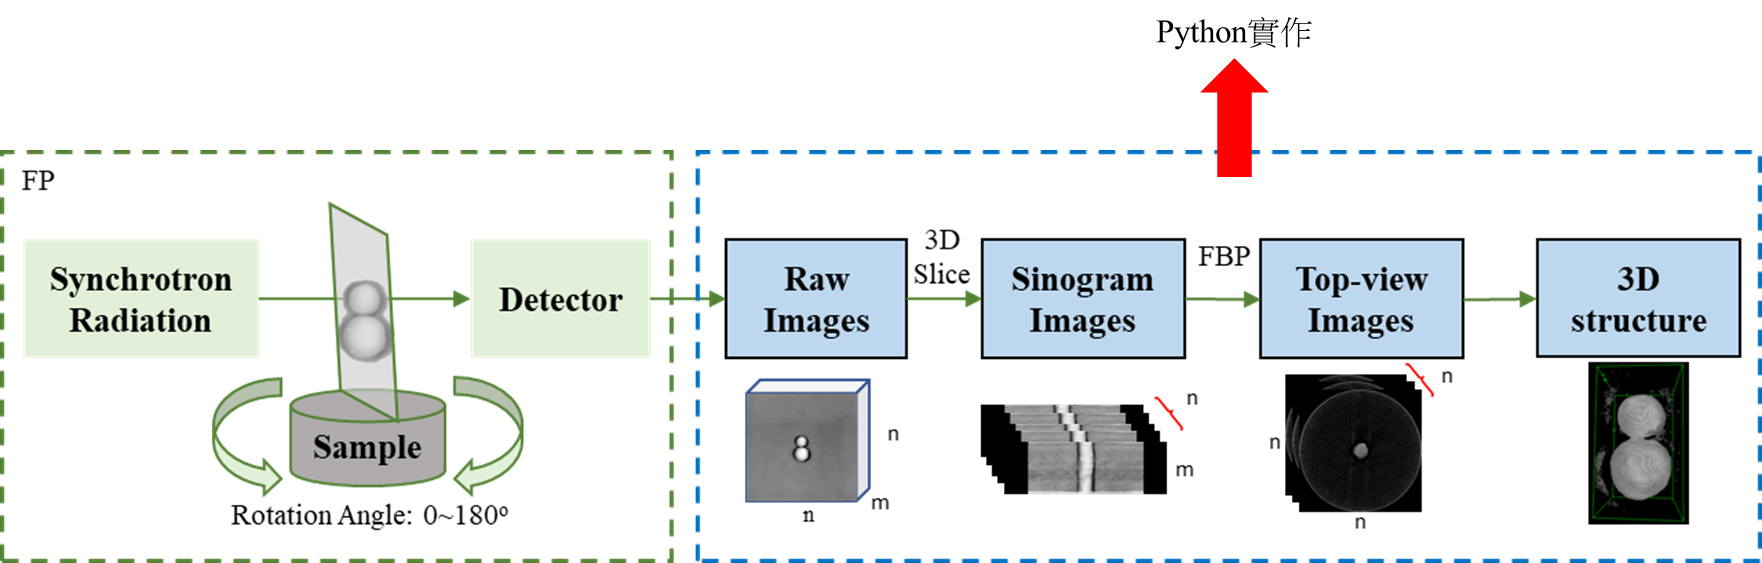

## 實作流程

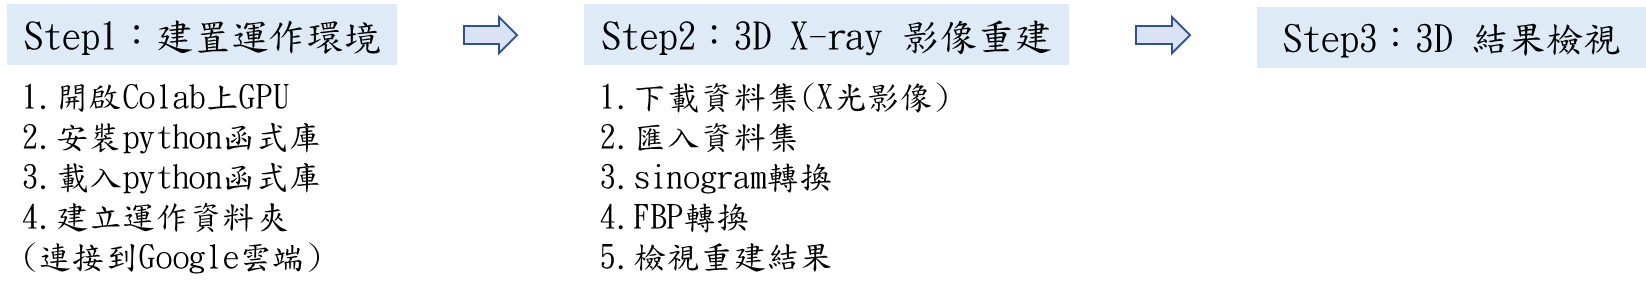

# 二、python實作：3D X-ray CT影像重建

## 建置運作環境

### 1.開啟Colab上GPU

1.編輯 -> 筆記本設定

2.硬體加速器 -> 點選GPU

3.儲存

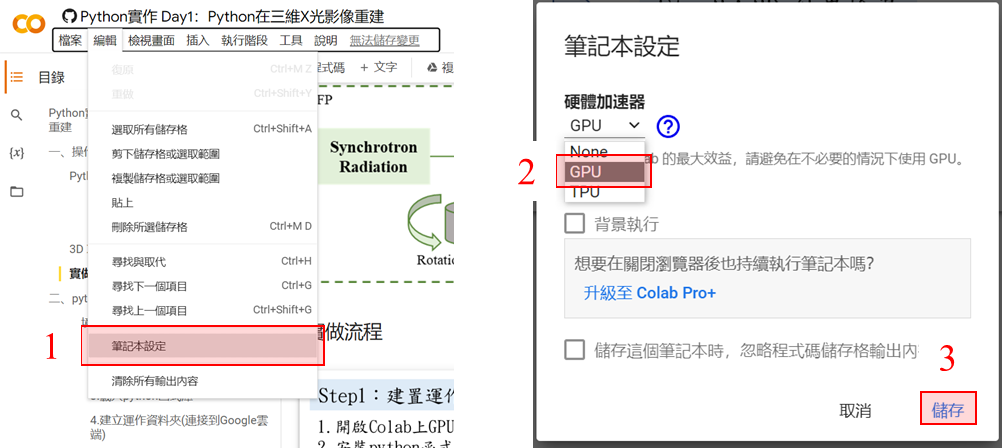

In [ ]:
!nvidia-smi

Tue Aug 23 16:51:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tesla T4：
https://www.nvidia.com/zh-tw/data-center/tesla-t4/

In [ ]:
from IPython.display import Image
Image(url='https://i.ppfocus.com/2020/12/d4aebc0fe94e.jpg')

### 2.安裝python函式庫

安裝condacolab (run time: 約40s)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...


安裝tomography相關套件 (run time: 約200s)

In [ ]:
!git clone https://github.com/ahendriksen/noise2inverse.git root_dir
!mamba env update -n base -f root_dir/environment.yml
!pip install -e root_dir/.
!pip install matplotlib==3.1.3
!cp -r root_dir/noise2inverse '/usr/local/lib/python3.7/site-packages'
!pip install gdown

安裝3D viewer套件(itkwidgets)

In [ ]:
import sys
import gdown

!{sys.executable} -m pip install -q --upgrade --pre itk-io
!{sys.executable} -m pip install -q dask toolz scikit-image matplotlib "itkwidgets>=1.0a8"
url = "https://drive.google.com/u/1/uc?id=1uSy6afmmD8NkUdup9uz0QGp2rXtOQH5H&export=download"
gdown.download(url)
!mv viewer.py /usr/local/lib/python3.7/dist-packages/itkwidgets

重新啟動執行階段

In [3]:
exit()

清除暫存安裝檔

In [1]:
import shutil
shutil.rmtree('root_dir')

### 3.載入python函式庫

python基礎套件

In [9]:
import numpy as np
from pathlib import Path
import glob
import time
import gdown

影像處理

In [3]:
from matplotlib import pyplot as plt
from PIL import Image
import tifffile
from noise2inverse import tiffs, tomo
import tomosipo as ts
import tomopy
from skimage.transform import iradon
import foam_ct_phantom

ipython互動介面

In [4]:
%matplotlib inline
from ipywidgets import interact

itkwidgets 3D-viewer套件

In [ ]:
from urllib.request import urlretrieve
import os
import zipfile
import itk
import dask.array.image
from itkwidgets import view

### 4.建立運作資料夾(連接到Google雲端)

連接 Google 雲端硬碟

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. 點選'連線至 Google 雲端硬碟'

2. 點選要登入的帳戶

3. 點選'允許'



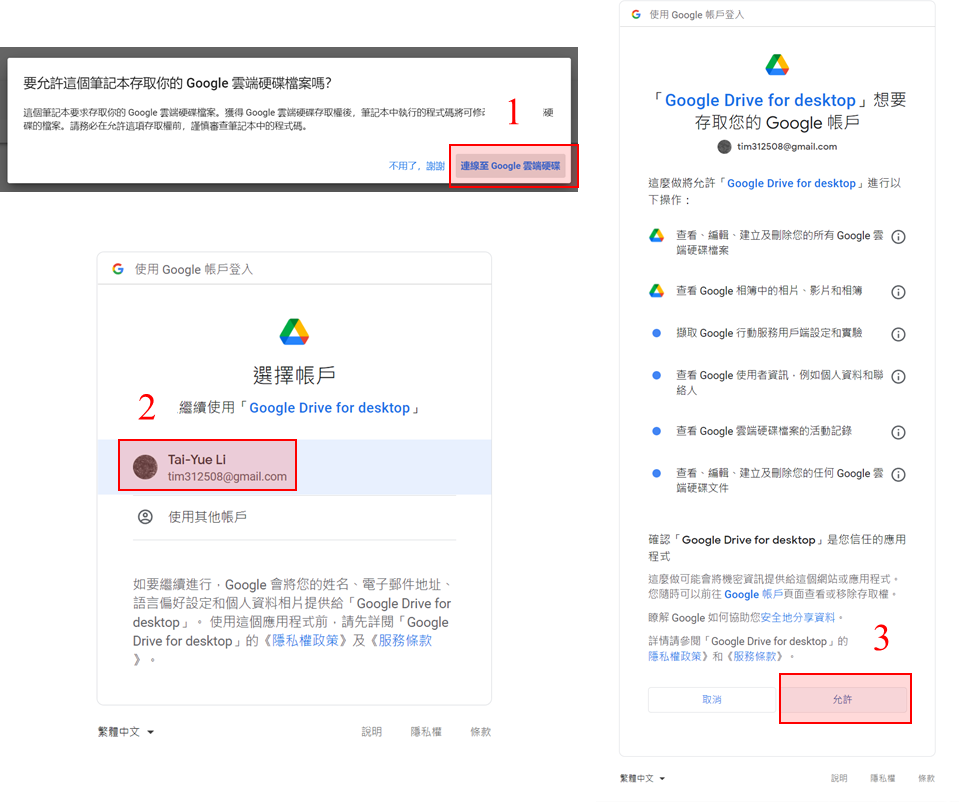

創建資料夾(day_1:tomography)

In [7]:
project_dir = Path("day_1:tomography")
project_dir.mkdir(exist_ok=True)

1.點選左側'檔案'

2.點選上方'重新整理'

3.可以看到創建的資料夾(day_1:tomography)

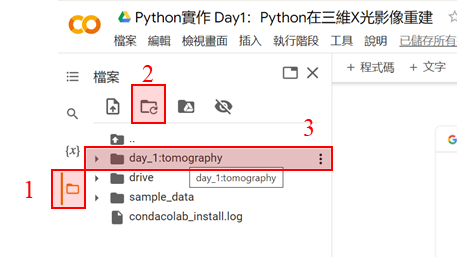

## 3D X-ray 影像重建

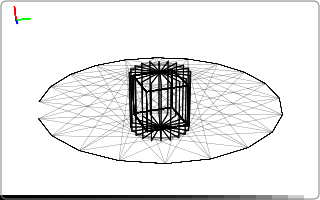

In [ ]:
pg = ts.cone(angles=20, size=np.sqrt(2), cone_angle=0.5)
vg = ts.volume()
ts.svg(pg, vg)

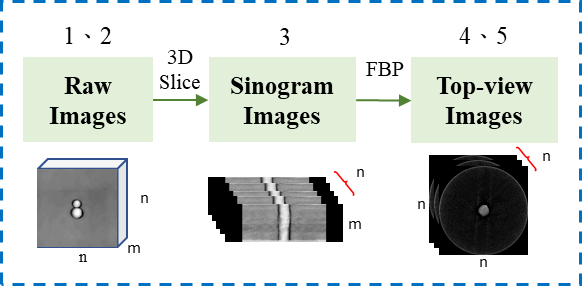

### 1.下載資料集(奈米金顆粒X光影像)

In [ ]:
%cd $project_dir
url = "https://drive.google.com/u/1/uc?id=1ysh7W43fKfU4saKh3ZnDw_XKVweOuNUY&export=download"
output = "temp.zip"
gdown.download(url, output)
!unzip temp.zip
!rm temp.zip
%cd ..

1.點選'三角形符號'和上方'重新整理'

2.可以看到下載的資料集在'Input_dataset_128'資料夾裡面

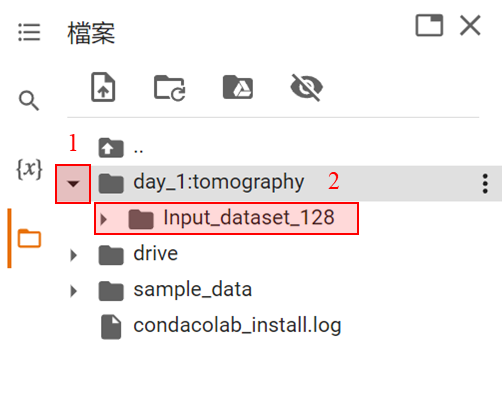

### 2.匯入資料集

In [32]:
image_stack=[]
for filename in sorted(glob.glob(str(project_dir/'Input_dataset'/"input_*.tif"))):
  image = tifffile.imread(filename)
  image_stack.append(image)
print(len(image_stack))

181


瀏覽角度0~180的影像

(可以拖動滑條瀏覽不同角度的影像)

In [33]:
def browse_images(image_stack):
    n = len(image_stack)
    def view_image(angle):
        plt.imshow(image_stack[angle], cmap="gray", interpolation='nearest')
        plt.title('Angle: %s' % angle)
        plt.show()
    interact(view_image, angle=(0,n-1))
browse_images(image_stack)

interactive(children=(IntSlider(value=90, description='angle', max=180), Output()), _dom_classes=('widget-inte…

### 3.sinogram轉換

In [41]:
sino = tiffs.load_sino(tiffs.glob(project_dir/'Input_dataset'))
print(' to ',len(sino),'sinograms')

181it [00:00, 594.66it/s]

 to  512 sinograms


瀏覽上到下0~127層的sinogram

(可以拖動滑條瀏覽不同層的sinograms)

In [42]:
def browse_images(sino):
    n = len(sino)
    def view_image(layer):
        plt.imshow(sino[layer], cmap="gray", interpolation='nearest')
        plt.title('layer: %s' % layer)
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(sino)

interactive(children=(IntSlider(value=255, description='layer', max=511), Output()), _dom_classes=('widget-int…

### 4.FBP：Filtered Backward Projection 

創建輸出資料夾

In [43]:
output_dir = Path(project_dir/"reconstructions")
output_dir.mkdir(exist_ok=True)

重建參數設定

In [44]:
start_angle, end_angle = 0, 180
angles_s = len(image_stack)
height_s, width_s = image_stack[0].shape

開始重建 

In [45]:
start = time.perf_counter()
sinogram = np.zeros((angles_s,width_s), np.uint8)
for j in range(height_s):
    sinogram_T = sino[j].T
    theta = np.linspace(start_angle, end_angle, angles_s, endpoint=True)    
    fbp = iradon(sinogram_T, theta=theta, filter_name='ramp',preserve_range=True)*20
    img_save = Image.fromarray(fbp)
    if img_save.mode == "F":
        save = img_save.convert('L')     
    save.save(output_dir/'output_{}.tif'.format(str(j).zfill(5))) 
end = time.perf_counter()
print('CPU Done!!')
print('run time: ',round((end-start),2),'s')

CPU Done!!
run time:  341.75 s


1.點選'重新整理'

2.可以在'reconstructions'資料夾看見重建好的影像檔案

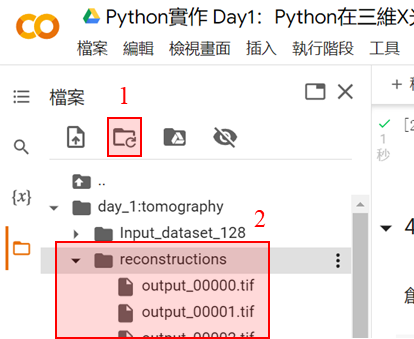

GPU加速(可選)

In [46]:
# GPU加速設定
start = time.perf_counter()
sino_float32 = (sino/255).astype(np.float32)
height, num_angles, width = sino_float32.shape

vol_shape = (height, width, width)
det_shape = (height, width)
angles = np.linspace(0, np.pi, num=num_angles, endpoint=False)
vg = ts.volume(size=vol_shape, pos=0, shape=vol_shape)
pg = ts.parallel(angles=angles, size=det_shape, shape=det_shape)
A = ts.operator(vg, pg)

# 開始重建
rec = tomo.fbp(A, sino_float32)
rec = tomopy.circ_mask(rec, axis=0, ratio=1.0)

# 存檔
# output_GPU_dir = Path(project_dir/"reconstructions_GPU")
# output_GPU_dir.mkdir(exist_ok=True)
# tiffs.save_stack(output_GPU_dir, rec)

end = time.perf_counter()
print('\n')
print('GPU Done!!')
print('run time: ',round((end-start),2),'s')



GPU Done!!
run time:  2.68 s


### 5.檢視重建結果

載入重建結果

In [47]:
output_stack=[]
for filename in sorted(glob.glob(str(output_dir/"output_*.tif"))):
  image = tifffile.imread(filename)
  output_stack.append(image)
print(len(output_stack))

512


瀏覽重建結果
(可以拖動滑條瀏覽不同層的重建結果)

In [48]:
def browse_images(output_stack):
    n = len(output_stack)
    def view_image(layer):
        plt.imshow(output_stack[layer], cmap="gray", interpolation='nearest')
        plt.title('layer: %s' % layer)
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(output_stack)

interactive(children=(IntSlider(value=255, description='layer', max=511), Output()), _dom_classes=('widget-int…

## 3D 圖像結果顯示

將重建結果匯入 3D-viewer

In [56]:
stack = dask.array.array(output_stack)
stack = stack[200:330,100:400,100:400]
stack

dask.array<getitem, shape=(130, 300, 300), dtype=uint8, chunksize=(74, 156, 156), chunktype=numpy.ndarray>

顯示3D 圖像結果 

(需要稍微等待一下)


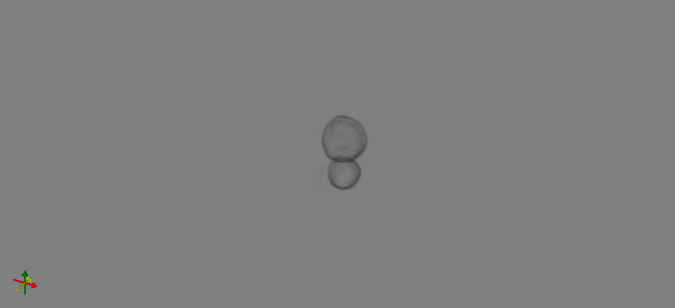
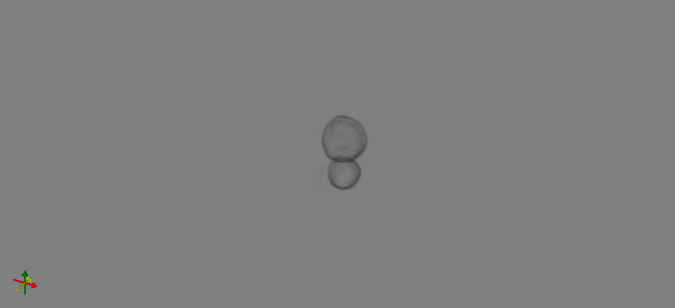

In [57]:
view(stack, shadow=False, gradient_opacity=0.4, ui_collapsed=True)